# PyEumap - Land Cover Mapping

In this tutorial, we will use the overlaid points (see [Overlay tutorial](02_overlay.ipynb)) to train a ML-model and predict the land cover (LC) in the last two decades, using the **LandMapper** class.

The training step will use **elevation**, **slope**, **landsat** (*7 spectral bands, 4 seasons and 3 percentiles per year*) and **night light** (*VIIRS Night Band*) data to predict the follow LC classes:
* 231: Pastures,
* 312: Coniferous forest,
* 321: Natural grasslands,
* 322: Moors and heathland,
* 324: Transitional woodland-shrub,
* 332: Bare rocks,
* 333: Sparsely vegetated areas,
* 335: Glaciers and perpetual snow.

First, let's import the necessary modules

In [1]:
import sys
sys.path.append('../../')

import os
import gdal
from pathlib import Path
import pandas as pd
import geopandas as gpd
from pyeumap.mapper import LandMapper

## Dataset

Our dataset refers to one tile, located in Switzerland, extracted from a tiling system created for Continental European (7,042 tiles) by GeoHarmonizer Project.

In [2]:
from pyeumap import datasets

tile = datasets.TILES[0]

data_root = datasets.DATA_ROOT_NAME
data_dir = Path(os.getcwd()).joinpath(data_root,tile)

print(f'data_dir = {data_dir}')

data_dir = /home/jupyter/leandro/Code/eumap/demo/python/eumap_data/10636_switzerland


Let's load the overlaid points

In [3]:
fn_points = Path(os.getcwd()).joinpath(data_dir, tile + '_landcover_samples_overlayed.gpkg')
points = gpd.read_file(fn_points)
points

,lucas,survey_date,confidence,tile_id,lc_class,overlay_id,dtm_elevation,dtm_slope,landsat_ard_winter_green_p75,landsat_ard_spring_green_p75,...,landsat_ard_summer_thermal_p75,landsat_ard_winter_thermal_p50,landsat_ard_winter_blue_p25,landsat_ard_fall_thermal_p50,landsat_ard_summer_thermal_p50,landsat_ard_spring_blue_p50,landsat_ard_fall_blue_p25,landsat_ard_spring_blue_p25,landsat_ard_summer_blue_p50,geometry
0,False,2006-06-30T00:00:00,85,10636,321,1,1948.0,36.313705,148.0,19.0,...,183.0,176.0,128.0,185.0,183.0,11.0,5.0,11.0,8.0,POINT (4145221.759 2594636.440)
1,False,2006-06-30T00:00:00,85,10636,321,2,2209.0,7.917305,135.0,159.0,...,182.0,176.0,118.0,183.0,182.0,120.0,5.0,96.0,5.0,POINT (4142366.664 2598169.380)
2,False,2006-06-30T00:00:00,85,10636,321,3,1990.0,32.722038,142.0,19.0,...,185.0,179.0,100.0,187.0,185.0,10.0,4.0,10.0,9.0,POINT (4140249.007 2596954.755)
3,False,2006-06-30T00:00:00,85,10636,322,4,2142.0,49.800537,47.0,36.0,...,179.0,175.0,48.0,179.0,179.0,37.0,7.0,37.0,2.0,POINT (4148638.412 2595538.585)
4,False,2006-06-30T00:00:00,85,10636,332,5,2420.0,27.018671,233.0,221.0,...,188.0,178.0,228.0,188.0,188.0,201.0,16.0,184.0,16.0,POINT (4156286.754 2595790.720)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,False,2000-06-30T00:00:00,85,10636,312,277,1729.0,16.108473,46.0,29.0,...,183.0,177.0,41.0,185.0,182.0,4.0,6.0,3.0,3.0,POINT (4140414.076 2582953.315)
1120,False,2000-06-30T00:00:00,85,10636,332,278,2562.0,31.661921,37.0,91.0,...,181.0,170.0,44.0,178.0,181.0,93.0,7.0,93.0,9.0,POINT (4157045.539 2609917.600)
1121,False,2000-06-30T00:00:00,85,10636,321,279,2174.0,15.649096,169.0,19.0,...,185.0,177.0,145.0,186.0,185.0,8.0,5.0,6.0,5.0,POINT (4141237.722 2583848.400)
1122,False,2000-06-30T00:00:00,85,10636,333,280,2368.0,21.605083,84.0,69.0,...,187.0,177.0,82.0,188.0,187.0,50.0,28.0,47.0,22.0,POINT (4141257.016 2584469.100)


What are the columns avaiable to the ML-model ?

In [4]:
print("Columns:")
columns = []
for col_name, col_type in zip(points.columns, points.dtypes):
    print(f' - {col_name} ({col_type})')

Columns:
 - lucas (bool)
 - survey_date (object)
 - confidence (int64)
 - tile_id (int64)
 - lc_class (int64)
 - overlay_id (int64)
 - dtm_elevation (float64)
 - dtm_slope (float64)
 - landsat_ard_winter_green_p75 (float64)
 - landsat_ard_spring_green_p75 (float64)
 - landsat_ard_winter_nir_p75 (float64)
 - landsat_ard_summer_green_p75 (float64)
 - landsat_ard_winter_nir_p25 (float64)
 - landsat_ard_spring_nir_p50 (float64)
 - landsat_ard_fall_nir_p25 (float64)
 - landsat_ard_summer_nir_p75 (float64)
 - landsat_ard_summer_nir_p50 (float64)
 - landsat_ard_fall_green_p25 (float64)
 - landsat_ard_winter_green_p25 (float64)
 - landsat_ard_fall_nir_p75 (float64)
 - landsat_ard_winter_green_p50 (float64)
 - landsat_ard_spring_nir_p25 (float64)
 - landsat_ard_winter_nir_p50 (float64)
 - landsat_ard_spring_green_p25 (float64)
 - landsat_ard_spring_blue_p75 (float64)
 - landsat_ard_summer_nir_p25 (float64)
 - landsat_ard_fall_green_p75 (float64)
 - landsat_ard_summer_green_p50 (float64)
 - land

## Training 

To map the land cover we will use the **LandMapper** class, which will train a ML-model and do spacetime predictions for diferent years. This class will receive a model implementation compatible with [sklearn](https://scikit-learn.org/stable/modules/classes.html) (e.g. [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), [KerasClassifier](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier), [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)), and a [BaseSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) implementation to find the best hyperparamenter for the specified model. For the hyperparameter optimization it's possible to select diferent [scoring metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and hyperparameter range values. In this example we will use the [f1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), that is basically a weighted average between the [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) and [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score). It's possible use other [evaluation metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) modifing ou creating a new python function, that will be passed as parameter for the LandMapper class.

In the remote sensing area the precision was renamed to Producer's Accuracy (the producer of the classification is interested in understand how well a specific area on Earth can be mapped) and the recall was renamed to User's Accuracy (the user of classification is interested in check how well the map represents what is really on the ground) ([Story, 1986](https://www.asprs.org/wp-content/uploads/pers/1986journal/mar/1986_mar_397-399.pdf)).

In [5]:
from sklearn.metrics import f1_score

def f1_scorer(clf, X, y_true):
    y_pred = clf.predict(X)
    error = f1_score(y_true, y_pred, average='weighted')
    return error

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100)

hyperpar = GridSearchCV(
    estimator = estimator,
    scoring = f1_scorer,
    param_grid = {
     'max_depth': [5, None], 
     'max_features': [0.5, None]
    }
)

The evaluation metric will be calculated using a cross validation strategy, using diferente parts of samples to train and validate the model. Here we will use a 5-fold cv, but others [validation strategies](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) are also supported by LandMapper class.

The LandMapper receives the follow parameters:
* **points**: the geopackage filepath or [GeoPandas DataFrame](https://geopandas.org/reference/geopandas.GeoDataFrame.html) instance,
* **feat_col_prfxs**: the prefix of all columns that should be included as covariates in the feature space,
* **target_col**: the name of the column that should be considered as the target variable by the model,
* **estimator**: the model implementation, which could be any one available in the [sklearn](https://scikit-learn.org/stable/modules/classes.html),
* **hyperpar_selection**: the hyperparameter optimization implementation, which could be any one available in the [sklearn](https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers),
* **cv**: the cross-validation strategy according to [sklearn](https://scikit-learn.org/stable/modules/classes.html#splitter-classes),
* **min_samples_per_class**: the minimum sample proportion per class (all the classes with less than 5% of samples will be removed from the training),
* **verbose**: show debug information about the train and prediction steps.

In [7]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'

min_samples_per_class = 0.05
cv = 5

landmapper = LandMapper(points=points, 
                        feat_col_prfxs = feat_col_prfxs, 
                        target_col = target_col, 
                        estimator = estimator, 
                        hyperpar_selection = hyperpar,
                        cv = cv,
                        min_samples_per_class=min_samples_per_class,
                        verbose = True)

[15:53:00] Removing 74 samples due min_samples_per_class condition (< 0.05)
[15:53:00] Transforming target variable:
[15:53:00]  - Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[15:53:00]  - Transformed classes: [0 1 2 3 4 5 6 7]


Let's optimize and train the model:

In [8]:
landmapper.train()

[15:53:00] Optimizing hyperparameters for RandomForestClassifier
[15:53:34]  -0.60044 (+/-0.09921) from {'max_depth': 5, 'max_features': 0.5}
[15:53:34]  -0.59569 (+/-0.08735) from {'max_depth': 5, 'max_features': None}
[15:53:34]  -0.71259 (+/-0.06021) from {'max_depth': None, 'max_features': 0.5}
[15:53:34]  -0.70654 (+/-0.07443) from {'max_depth': None, 'max_features': None}
[15:53:34] Best: 0.71259 using {'max_depth': None, 'max_features': 0.5}
[15:53:34] Calculating evaluation metrics


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[15:53:42] Training RandomForestClassifier using all samples


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s finished


Let's understand what happened here:
1. Diferent combinations of hyperparameters where evaluated
2. The best one was chosen and all the samples were cross validated to derive other classification metrics
3. A final model were trained using all the samples, without cv. This model will be used to classify the land-cover in future prediction

We can check other classification metrics for the best classification models

In [9]:
print(f'Overall accuracy: {landmapper.eval_metrics["overall_acc"] * 100:.2f}%\n\n')
print(landmapper.eval_report)

Overall accuracy: 72.10%


              precision    recall  f1-score   support

           0       0.78      0.70      0.74        66
           1       0.67      0.79      0.73       199
           2       0.67      0.75      0.71       166
           3       0.59      0.54      0.57       116
           4       0.42      0.20      0.27        84
           5       0.79      0.70      0.74       101
           6       0.79      0.84      0.82       229
           7       0.93      0.97      0.95        89

    accuracy                           0.72      1050
   macro avg       0.71      0.69      0.69      1050
weighted avg       0.71      0.72      0.71      1050



... and the complete confusion matrix:

Verifing the label order:
 - 0 => 231: Pastures
 - 1 => 312: Coniferous forest
 - 2 => 321: Natural grasslands
 - 3 => 322: Moors and heathland
 - 4 => 324: Transitional woodland-shrub
 - 5 => 332: Bare rocks
 - 6 => 333: Sparsely vegetated areas
 - 7 => 335: Glaciers and perpetual snow


Confusion Matrix:


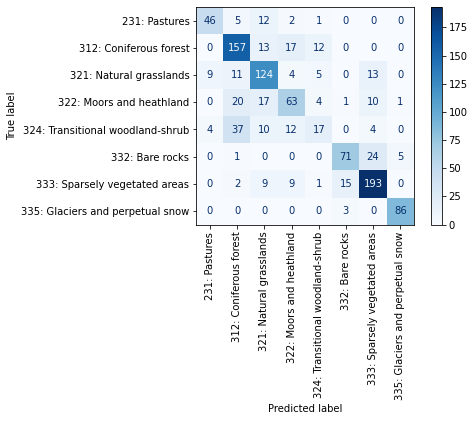

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = [
    '231: Pastures',
    '312: Coniferous forest',
    '321: Natural grasslands',
    '322: Moors and heathland',
    '324: Transitional woodland-shrub',
    '332: Bare rocks',
    '333: Sparsely vegetated areas',
    '335: Glaciers and perpetual snow'
]

estimator = landmapper.estimator_list[0]
print("Verifing the label order:")
for label, cl in zip(labels, estimator.classes_):
    print(f' - {cl:.0f} => {label}')

print("\n\nConfusion Matrix:")
confusion_matrix = landmapper.eval_metrics['confusion_matrix']
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
disp.plot(cmap='Blues', xticks_rotation='vertical')

You can also can access the raw cv results:

In [11]:
pd.DataFrame({
    'Expected LC-class':landmapper.target,
    'Predict LC-class': landmapper.eval_pred}
)

,Expected LC-class,Predict LC-class
0,2,2
1,2,2
2,2,2
3,3,3
4,5,6
...,...,...
1045,1,1
1046,5,6
1047,2,2
1048,6,6


## Predictions

Now we are ready to run the predictions. To do it the **LandMapper** needs receive as parameter:
* **dirs_layers**: a list containing diferent folders that store the same raster layers used in the spacetive overlay and training phase,
* **fn_output**: the file path to write the model output as geotiff.

First, let's predict only the year of 2000:

In [12]:
dir_timeless_layers = os.path.join(data_dir, 'timeless') 
dir_2000_layers = os.path.join(data_dir, '2000')

dirs_layers = [dir_2000_layers, dir_timeless_layers]
fn_output = os.path.join(data_dir, 'land_cover_2000.tif')

output_fn_files = landmapper.predict(dirs_layers=dirs_layers, fn_output=fn_output)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {output_fn_file}')

[15:53:45] Reading 87 raster files
[15:53:51] Executing RandomForestClassifier
[15:54:07] RandomForestClassifier prediction time: 16.46 segs
Output files:
 - /home/jupyter/leandro/Code/eumap/demo/python/eumap_data/10636_switzerland/land_cover_2000.tif


Now we are ready to predict multiple years, creating a list of **dirs_layers** and **fn_output**, and passing to the method **predict_multi**, which will perform this task in parallel:

In [19]:
dir_timeless_layers = os.path.join(data_dir, 'timeless') 

dirs_layers_list = []
fn_output_list = []

for year in range(2000, 2004):
    dir_time_layers = os.path.join(data_dir, str(year))
    dirs_layers = [dir_time_layers, dir_timeless_layers]
    fn_result = os.path.join(data_dir, f'land_cover_{year}.tif')
    
    dirs_layers_list.append(dirs_layers)
    fn_output_list.append(fn_result)

output_fn_files = landmapper.predict_multi(dirs_layers_list=dirs_layers_list, fn_output_list=fn_output_list)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {output_fn_file}')

[10:41:49] Reading 87 raster files
[10:41:55] 1) Reading time: 6.43 segs
[10:41:55] [10:41:55] Reading 87 raster files
1) Predicting 1000000 pixels
[10:41:55] Executing RandomForestClassifier
[10:42:00] 2) Reading time: 5.40 segs
[10:42:00] Reading 87 raster files
[10:42:06] 3) Reading time: 5.08 segs
[10:42:06] Reading 87 raster files
[10:42:11] 4) Reading time: 5.08 segs
[10:42:13] RandomForestClassifier prediction time: 17.71 segs
[10:42:13] 1) Predicting time: 17.72 segs
[10:42:18] 2) Predicting 1000000 pixels
[10:42:18] 1) Saving time: 0.06 segs
[10:42:19] Executing RandomForestClassifier
[10:42:33] RandomForestClassifier prediction time: 14.47 segs
[10:42:33] 2) Predicting time: 14.47 segs
[10:42:33] 3) Predicting 1000000 pixels
[10:42:33] 2) Saving time: 0.03 segs
[10:42:33] Executing RandomForestClassifier
[10:42:48] RandomForestClassifier prediction time: 14.14 segs
[10:42:48] 3) Predicting time: 14.14 segs
[10:42:48] 4) Predicting 1000000 pixels
[10:42:48] 3) Saving time: 0.0

The generated geotiff files will have the following pixel values. 

In [20]:
import numpy as np
from matplotlib.colors import ListedColormap

lc_classes = landmapper.target_classes['original']
pixel_values = landmapper.target_classes['transformed']
colors = ListedColormap(["red", "darkred", "springgreen", "green", "darkgreen", "yellow", "tan", "white"])

print("Mapped land cover classes")
for l, p, c in zip(lc_classes, pixel_values, colors.colors):
    print(f' - {l:.0f} => pixel value {p} ({c})')

Mapped land cover classes
 - 231 => pixel value 0 (red)
 - 312 => pixel value 1 (darkred)
 - 321 => pixel value 2 (springgreen)
 - 322 => pixel value 3 (green)
 - 324 => pixel value 4 (darkgreen)
 - 332 => pixel value 5 (yellow)
 - 333 => pixel value 6 (tan)
 - 335 => pixel value 7 (white)


Let's see the the prediction results:

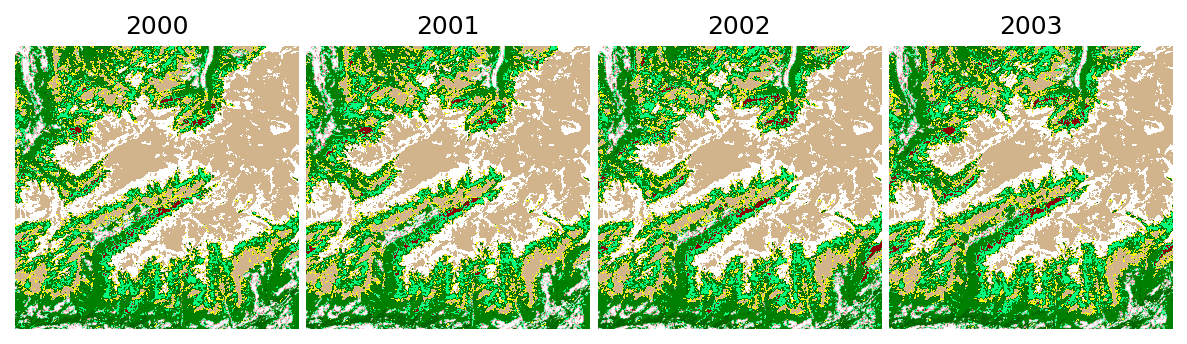

In [21]:
from pyeumap.plotter import plot_rasters

titles = range(2000, 2000+len(lc_classes))
plot_rasters(*output_fn_files, cmaps = colors, titles = titles)